In [ ]:
!pip3 install imutils

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/drive/MyDrive/MAJOR PROJECT/Brain-Tumor-Detection-with-VGG16-main/archive/brain_tumor_dataset"))
data = []
labels = []

for imagePath in imagePaths:

	label = imagePath.split(os.path.sep)[-2]


	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))


	data.append(image)
	labels.append(label)


data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

[INFO] loading images...


In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20,
                                                  stratify=labels, random_state=42)

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

# load the VGG16 network, ensuring the head fully connected layer sets are left off
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [ ]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

**Initialising learning rate as 1e-3 , epochs as 25 and batch size as 8**

In [ ]:
import tensorflow as tf

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = tf.keras.optimizers.legacy.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...


<ipython-input-10-88f7e153467d>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/25
25/25 [==============================] - 154s 6s/step - loss: 0.6911 - accuracy: 0.6392 - val_loss: 0.6425 - val_accuracy: 0.6078
Epoch 2/25
25/25 [==============================] - 162s 6s/step - loss: 0.6677 - accuracy: 0.6340 - val_loss: 0.6001 - val_accuracy: 0.6078
Epoch 3/25
25/25 [==============================] - 165s 7s/step - loss: 0.6351 - accuracy: 0.6546 - val_loss: 0.5821 - val_accuracy: 0.8039
Epoch 4/25
25/25 [==============================] - 162s 7s/step - loss: 0.6283 - accuracy: 0.7010 - val_loss: 0.5604 - val_accuracy: 0.8039
Epoch 5/25
25/25 [==============================] - 161s 7s/step - loss: 0.5900 - accuracy: 0.7320 - val_loss: 0.5406 - val_accuracy: 0.8039
Epoch 6/25
25/25 [==============================] - 165s 7s/step - loss: 0.5662 - accuracy: 0.7423 - val_loss: 0.5171 - val_accuracy: 0.8039
Epoch 7/25
25/25 [==============================] - 166s 7s/step - loss: 0.5439 - accuracy: 0.7526 - val_loss: 0.5370 - val_accuracy: 0.7843
Epoch 8/25
25

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[INFO] evaluating network...
7/7 [==============================] - 30s 4s/step
              precision    recall  f1-score   support

          no       0.70      0.70      0.70        20
         yes       0.81      0.81      0.81        31

    accuracy                           0.76        51
   macro avg       0.75      0.75      0.75        51
weighted avg       0.76      0.76      0.76        51

[[14  6]
 [ 6 25]]
acc: 0.7647
sensitivity: 0.7000
specificity: 0.8065


**There are 95 correct observations out of 102 (total observations)**

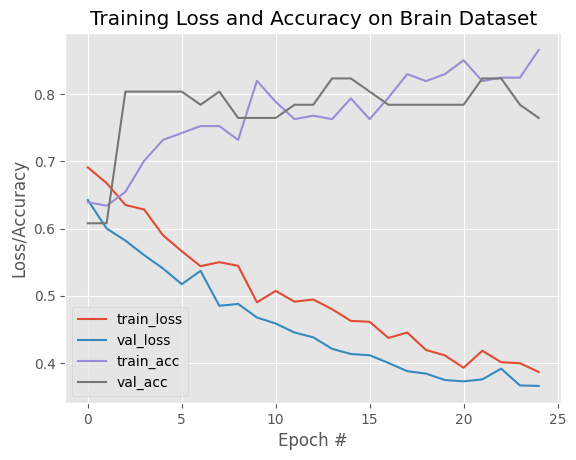

In [ ]:
#plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.jpg")

In [ ]:
# serialize the model to disk
print("[INFO] saving Brain Tumor detector model...")
model.save("brain.model", save_format="h5")

[INFO] saving Brain Tumor detector model...


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Result

**We are getting an accuracy of 93% with Sensitivity as 0.95 and Specificity as 0.91**